# Cancer Detection
The goal of this project is to utilize machine learning to determine if an image is cancer. I am going to use EDA to visualize the images of cancer. Then create a model that can accurately determine if an image of cells is cancerous or not.

In [161]:
#Importing in necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
import os
import random
from keras.optimizers import Adam
from keras.applications import VGG16
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import keras_tuner as kt
from tensorflow.keras.applications import ResNet50

## EDA and Cleaning

In [2]:
labels_df = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')

In [3]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [4]:
labelCounts = labels_df['label'].value_counts()
labelCounts

label
0    130908
1     89117
Name: count, dtype: int64

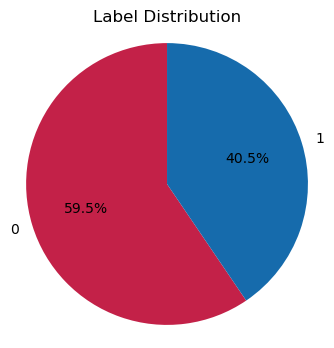

In [5]:
plt.figure(figsize=(4,4))
plt.pie(labelCounts, labels=labelCounts.index, autopct='%1.1f%%', startangle=90, colors=['#c32148','#166bac'])
plt.title('Label Distribution')
plt.axis('equal')
plt.show()

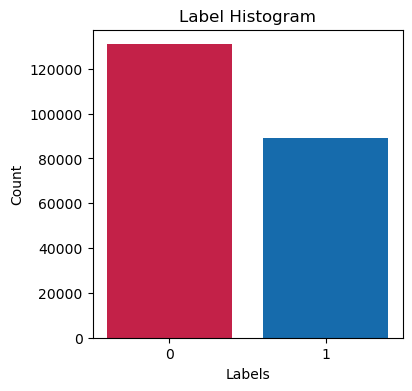

In [125]:
label_counts = {'0': 130908, '1': 89117}
plt.figure(figsize=(4,4))
plt.bar(label_counts.keys(), label_counts.values(), color=['#c32148','#166bac'])
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Histogram')
plt.show()

Since there is a lot of data I am going to drop all from the dataframe except 5,000 samples from label 0 and 5,000 from label 1. Unfortunately, I do not have a very powerful computer that can handle all the data.

Another decision I am making is just to analyze the center 32 by 32 pixel image, and convert the images to pixel values and normalized them. This will also help on computational bandwidth.

In [78]:
#Sampling the data, even number of label 0 and label 1 so model get data represented 
#by both label 1 and label 0
sampledLabelsDF = labels_df.groupby('label').sample(n=5000, random_state=42)

In [79]:
sampledLabelsDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 121450 to 186626
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10000 non-null  object
 1   label   10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 234.4+ KB


In [6]:
#sampledLabelsDF.to_csv('sampled_labels.csv', index=False)
#save it to a csv so we don't change what we sample,
labelsDF = pd.read_csv('sampled_labels.csv')
labelsDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10000 non-null  object
 1   label   10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [148]:
labelCounts2 = labelsDF['label'].value_counts()
labelCounts2

label
0    5000
1    5000
Name: count, dtype: int64

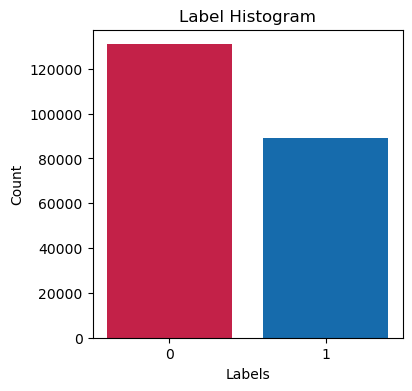

In [149]:
label_counts2 = {'0': 130908, '1': 89117}
plt.figure(figsize=(4,4))
plt.bar(label_counts2.keys(), label_counts2.values(), color=['#c32148','#166bac'])
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Histogram')
plt.show()

#### Visualizing Images
Visualizing the images to see difference in label 1 vs label 0

In [34]:
def showImages(images, title):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
    fig.suptitle(title, fontsize=16)
    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.axis('off')
    plt.show()

def displayImages(folder, labelsDF, label_value, num_images=5, image_size=(128, 128)):
    filtered_df = labelsDF[labelsDF['label'] == label_value]
    images = []
    count = 0
    for _, row in filtered_df.iterrows():
        if count >= num_images:
            break
        imgID = row['id']
        imgPath = os.path.join(folder, f"{imgID}.tif")
        if os.path.exists(imgPath):
            with Image.open(imgPath) as img:
                img = img.resize(image_size)
                images.append(img)
            count += 1
    
    showImages(images, f"Label {label_value}")

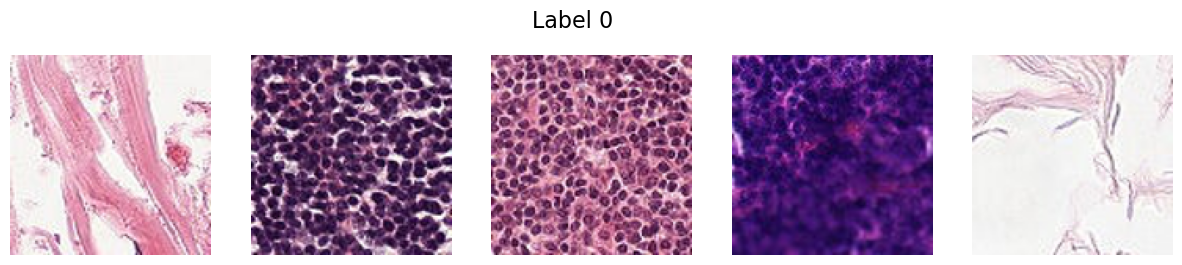

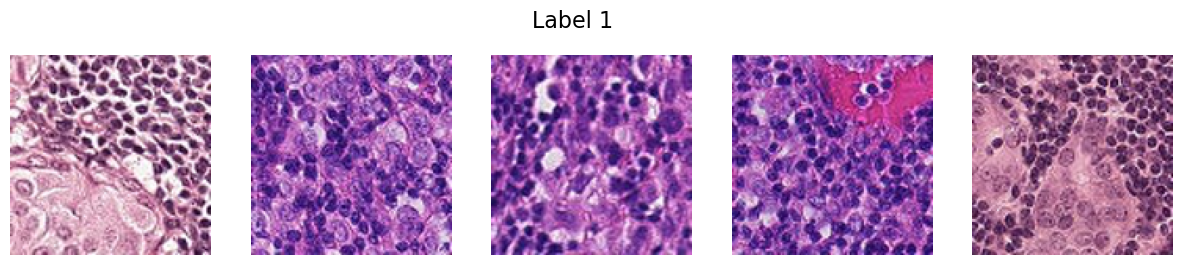

In [35]:
displayImages('histopathologic-cancer-detection/train', labelsDF, label_value=0, num_images=5)
displayImages('histopathologic-cancer-detection/train', labelsDF, label_value=1, num_images=5)



In [93]:
#Due to computational limitations of my machine I am only considering a 32 by 32 center
#portion of each image of my 10,000 image sample set

def cropToCenter (image, cropwidth, cropheight):
    imgwidth, imgheight = image.size
    left = (imgwidth-cropwidth)/2
    top = (imgheight-cropheight)/2
    right = (imgwidth+cropwidth)/2
    bottom = (imgheight+cropheight)/2
    return image.crop((left, top, right, bottom))

def loadImages(folder, labelsDF=None):
    images = []
    labels = []
    filenames = []
    sampled = set(labelsDF['id'].values) if labelsDF is not None else None
    for file in os.listdir(folder):
        imgID = os.path.splitext(file)[0]
        if sampled is None or imgID in sampled:
            imgPath = os.path.join(folder,file)
            with Image.open(imgPath) as img:
                img = cropToCenter(img, 32,32)
                imgArr = np.array(img)
            images.append(imgArr)
            filenames.append(imgID)
            if labelsDF is not None:
                label = labelsDF[labelsDF['id'] == imgID]['label'].values[0]
                labels.append(label)
        
    images = np.array(images)
    label = np.array(labels) if labels else None
    return images, labels, filenames

#Create testing and training sets of pixel values

train_images, train_labels,_ = loadImages('histopathologic-cancer-detection/train', labelsDF)
test_images, _, testimages_ids = loadImages('histopathologic-cancer-detection/test')

In [94]:
#Normalizing images
trainImages = train_images/255
testImages = test_images/255

In [95]:
#Split into training and validation
Xtrain, Xval, ytrain, yval = train_test_split(trainImages, train_labels, test_size=0.2, random_state=42)


In [96]:
#Converting ytrain and yval into arrays for model
ytrain = np.array(ytrain)
yval = np.array(yval)

In [97]:
#Double checking that the shapes of the arrays are as expected and splitting worked
print("Shape of Xtrain:", Xtrain.shape)
print("Shape of ytrain:", ytrain.shape)
print("Shape of Xval:", Xval.shape)
print("Shape of yval:", yval.shape)

Shape of Xtrain: (8000, 32, 32, 3)
Shape of ytrain: (8000,)
Shape of Xval: (2000, 32, 32, 3)
Shape of yval: (2000,)


## First Model

For my models I am using VGG16 due to its reduced time needed to train, good accuracy and good extraction of features of images

In [98]:
firstModelBase = VGG16(weights='imagenet', include_top=False, input_shape=(32,32,3))
firstModel = Sequential([firstModelBase, 
                         GlobalAveragePooling2D(),
                        Dense(128, activation='relu'),
                        Dropout(0.5),
                        Dense(1,activation='sigmoid')])

In [99]:
firstModel.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [100]:
firstModel.fit(Xtrain, ytrain, epochs=10, validation_data=(Xval,yval), batch_size=32)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 83s 327ms/step - accuracy: 0.6652 - loss: 0.6164 - val_accuracy: 0.7700 - val_loss: 0.5129
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 107s 428ms/step - accuracy: 0.7689 - loss: 0.5050 - val_accuracy: 0.7765 - val_loss: 0.4952
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 151s 605ms/step - accuracy: 0.7791 - loss: 0.4847 - val_accuracy: 0.7545 - val_loss: 0.5105
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 216s 866ms/step - accuracy: 0.8008 - loss: 0.4481 - val_accuracy: 0.7625 - val_loss: 0.4904
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 75s 301ms/step - accuracy: 0.8090 - loss: 0.4268 - val_accuracy: 0.7860 - val_loss: 0.4692
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 102s 407ms/step - accuracy: 0.8336 - loss: 0.3813 - val_accuracy: 0.7550 - val_loss: 0.5938
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 106s 425ms/step - accuracy: 0.8553 - loss: 0.3395 - val_accuracy: 0.7925 - val_loss: 0.4916
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 107s 428ms/step - accuracy: 0.8831 - l

In [101]:
predictions = firstModel.predict(test_images)
predicted_labels=(predictions>0.5).astype(int)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 161s 90ms/step


In [118]:
output_df = pd.DataFrame({
    'id': testimages_ids,
    'label': predicted_labels.flatten()
})


In [119]:
output_df.head()

,id,label
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d,1
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581,1
2,19709bec800f372d0b1d085da6933dd3ef108846,1
3,7a34fc34523063f13f0617f7518a0330f6187bd3,0
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed,0


In [121]:
output_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      57458 non-null  object
 1   label   57458 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 897.9+ KB


In [114]:
valpredictions = firstModel.predict(Xval)
valpredLabels = (valpredictions > 0.5).astype(int).flatten()

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step


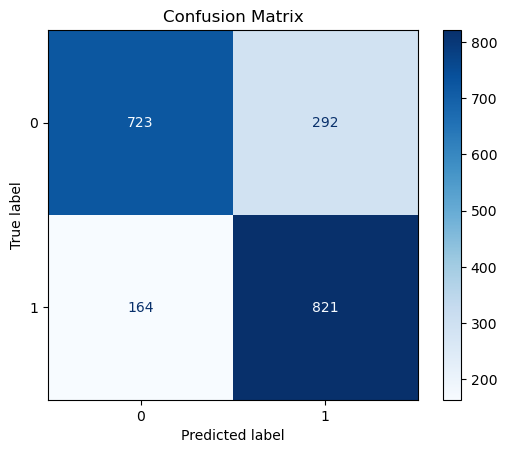

In [115]:
cm = confusion_matrix(yval, valpredLabels)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


This is a pretty good result, and an accuracy of approximately 0.92

In [120]:
#This is a pretty good so going to export this to a csv
#output_df.to_csv('output1.csv', index=False)


#### Result for the first model
![Result](firstmodel.png)

In [128]:
#Now hyperparameter tuning
def build_model(hp):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32,32,3))
    base_model.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(hp.Int('units', min_value=64, max_value=256, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [133]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=4,
    factor=3,
    directory='my_dir3',
    project_name='histo_cancer_detection3'
)

tuner.search(Xtrain, ytrain, epochs=4, validation_data=(Xval, yval))

Trial 10 Complete [00h 04m 03s]
val_accuracy: 0.7605000138282776

Best val_accuracy So Far: 0.7705000042915344
Total elapsed time: 00h 20m 55s


In [157]:
bestHPs = tuner.get_best_hyperparameters(num_trials=10)[0]
tunedModel = tuner.hypermodel.build(bestHPs)

In [158]:
print("Best Hyperparameters")
print(f"Units in Dense layer: {bestHPs.get('units')}")
print(f"Dropout rate: {bestHPs.get('dropout')}")
print(f"Learning rate: {bestHPs.get('learning_rate')}")

Best Hyperparameters
Units in Dense layer: 256
Dropout rate: 0.4
Learning rate: 0.001


Because hyperparameters are so close to the initially used parameters, very unlikely to see improvement

In [143]:
history = tunedModel.fit(Xtrain, ytrain, epochs=10, validation_data=(Xval, yval))

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - accuracy: 0.6953 - loss: 0.5839 - val_accuracy: 0.7550 - val_loss: 0.5347
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 140ms/step - accuracy: 0.7522 - loss: 0.5131 - val_accuracy: 0.7630 - val_loss: 0.5114
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 127ms/step - accuracy: 0.7641 - loss: 0.5009 - val_accuracy: 0.7685 - val_loss: 0.4956
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 126ms/step - accuracy: 0.7682 - loss: 0.4928 - val_accuracy: 0.7460 - val_loss: 0.5035
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.7697 - loss: 0.4902 - val_accuracy: 0.7570 - val_loss: 0.5021
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 31s 122ms/step - accuracy: 0.7681 - loss: 0.4822 - val_accuracy: 0.7580 - val_loss: 0.5032
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 127ms/step - accuracy: 0.7827 - loss: 0.4725 - val_accuracy: 0.7655 - val_loss: 0.4935
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 130ms/step - accuracy: 0.7857 - loss: 0

In [144]:
valpredictions2 = tunedModel.predict(Xval)
valpredLabels2 = (valpredictions2 > 0.5).astype(int).flatten()

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step


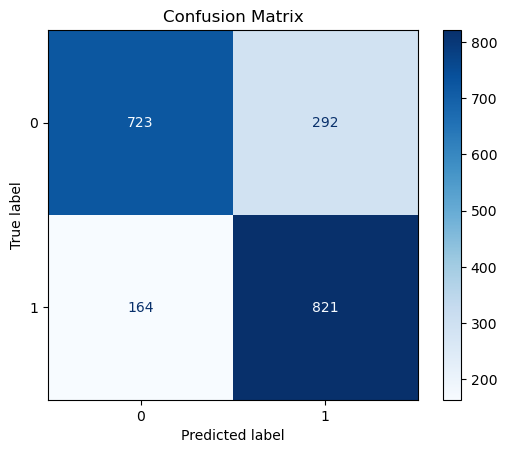

In [145]:
cm2 = confusion_matrix(yval, valpredLabels2)
cmdisplay2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=[0, 1])
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [146]:
testpredictions2 = tunedModel.predict(test_images)
testpredlabels2 = (testpredictions2 > 0.5).astype(int)


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 175s 98ms/step


In [147]:
outputdf2 = pd.DataFrame({'id': testimages_ids, 'label': testpredlabels2.flatten()})

In [159]:
#Lastly saving to a csv
#outputdf2.to_csv('output2.csv', index=False)

#### Result for the second model
![Result](secondmodel.png)

## Last Model

For the last model I am going to use ResNet50, I will do hyperparameter tuning first

I am choosing ResNet50 is another model that has successfully evaluated images and is built into Python Keras library

In [162]:
def build_model_resnet(hp):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32,32,3))
    base_model.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(hp.Int('units', min_value=64, max_value=256, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

tuner_resnet = kt.Hyperband(
    build_model_resnet,
    objective='val_accuracy',
    max_epochs=4,
    factor=3,
    directory='my_dir_resnet',
    project_name='histo_cancer_detection_resnet'
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


In [163]:
tuner_resnet.search(Xtrain, ytrain, epochs=4, validation_data=(Xval, yval))

Trial 10 Complete [00h 01m 32s]
val_accuracy: 0.6244999766349792

Best val_accuracy So Far: 0.6244999766349792
Total elapsed time: 00h 08m 00s


In [164]:
bestHPs_resnet = tuner_resnet.get_best_hyperparameters(num_trials=10)[0]
tunedModel_resnet = tuner_resnet.hypermodel.build(bestHPs_resnet)


In [170]:
print("Best Hyperparameters")
print(f"Units in Dense layer: {bestHPs_resnet.get('units')}")
print(f"Dropout rate: {bestHPs_resnet.get('dropout')}")
print(f"Learning rate: {bestHPs_resnet.get('learning_rate')}")

Best Hyperparameters
Units in Dense layer: 256
Dropout rate: 0.2
Learning rate: 0.0001


In [165]:
history_resnet = tunedModel_resnet.fit(Xtrain, ytrain, epochs=10, validation_data=(Xval, yval))

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 94ms/step - accuracy: 0.4966 - loss: 0.7709 - val_accuracy: 0.5755 - val_loss: 0.6771
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.5394 - loss: 0.7011 - val_accuracy: 0.6060 - val_loss: 0.6673
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.5779 - loss: 0.6741 - val_accuracy: 0.6260 - val_loss: 0.6590
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.5995 - loss: 0.6664 - val_accuracy: 0.6070 - val_loss: 0.6566
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.6180 - loss: 0.6598 - val_accuracy: 0.5845 - val_loss: 0.6612
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - accuracy: 0.6223 - loss: 0.6567 - val_accuracy: 0.6390 - val_loss: 0.6485
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - accuracy: 0.6302 - loss: 0.6512 - val_accuracy: 0.6450 - val_loss: 0.6430
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.6346 - loss: 0.6455 - 

In [166]:
valpredictions3 = tunedModel_resnet.predict(Xval)
valpredLabels3 = (valpredictions3 > 0.5).astype(int).flatten()

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step


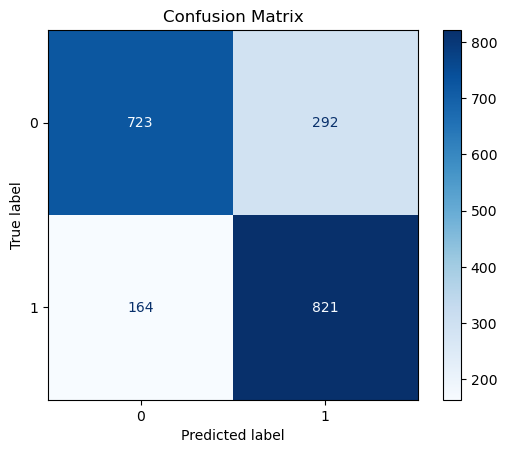

In [167]:
cm3 = confusion_matrix(yval, valpredLabels3)
cmdisplay3 = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=[0, 1])
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [168]:
testpredictions3 = tunedModel_resnet.predict(test_images)
testpredlabels3 = (testpredictions3 > 0.5).astype(int)


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 119s 66ms/step


In [169]:
outputdf3 = pd.DataFrame({'id': testimages_ids, 'label': testpredlabels3.flatten()})

In [171]:
#Lastly saving to a csv
#outputdf3.to_csv('output3.csv', index=False)

#### Result for the third model
![Result](thirdmodel.png)

## Conclusion
Overall I was most successful in my first attempt at the model. Overall VGG16 worked better than ResNet50. I believe this is because my dataset was not large enough for ResNet50 as it is prone to overfitting. Furthermore, tuning hyperparameters did not improve model performance for VGG16. This is because the initial parameters I chose are better than the parameters chosen by tuning. I believe if I did more iterations in tuning hyperparameters I would do more iterations for tuning hyperparameters in the future. Unfortunately, I have limited computational power on my laptop and was unable to do more iterations.